###  Planet Analytics API Tutorial

<h1 style="margin-top:10px;">Case Study: Flood and Displacement Mapping in Syria</h1>
</div>
<div class="content-block">

## Overview

1. [Setup](#1.-Setup)

2. [Case Study](#2.-Case-Study)

3. [Mapping our Area of Interest](#3.-Mapping-AOI)

4. [Working with Collections](#4.-Working-with-Collections)
    
5. [Parsing Results](#5.-Parse-Results-Links)
    
6. [Segmentation Results](#6.-Segmentation-Results)
    
7. [Quantifying Change](#7.-Quantifying-Change)
    
8. [Line Charts](#8.-Line-Charts)
    
</div>

Open this notebook in Colab below:

<a target="_blank" href="https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/analytics/case_study_syria_idp_camps.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 1. Setup
To run through this notebook, you will need access to the following:
- A Planet account and Planet API Key
- Access to the Analytics API

In [ ]:
# Import Packages

from ipyleaflet import Map, GeoJSON, LocalTileLayer, LayersControl, SplitMapControl, WidgetControl
from ipywidgets import SelectionSlider, VBox
import matplotlib.pyplot as plt
from numpy import mean
from numpy import count_nonzero
import os
import pandas as pd

from pprint import pprint
import rasterio
import requests
from rasterio.warp import transform_geom
from shapely.geometry import shape
from tqdm import tqdm

In [2]:
# If your Planet API Key is not set as an environment variable, you can paste it below
# Note: please be sure to follow the security guidelines put forth by your
# organization when using this API Key in the keychain
if os.environ.get('PL_API_KEY', ''):
    API_KEY = os.environ.get('PL_API_KEY', '')
else:
    API_KEY = 'PASTE YOUR API KEY HERE'

# Construct auth tuple for use in the requests library
BASIC_AUTH = (API_KEY, '')

**Set the base url for the Planet Analytic Feeds product**

See the [Analytics API Docs](https://developers.planet.com/docs/analytics/) for more details.

In [3]:
BASE_URL = "https://api.planet.com/analytics/"

Check API Connection

In [4]:
feed_list_url = BASE_URL + 'feeds'
resp = requests.get(feed_list_url, auth=BASIC_AUTH, params={'limit': 1})
if resp.status_code == 200:
    print('Yay, you can access the Analytics API')
else:
    print('Something is wrong:', resp.content)

NameError: name 'requests' is not defined

## 2. Case Study

Near the end of 2018, Syria experienced severe rainfall and flooding across much of the Northern latitudes of the country. This flooding had devastating impacts to several Internally Displaced Persons (IDP) camps  across the region, as [reported](https://www.savethechildren.net/news/northern-syria-flooding-thousands-children-risk-further-displacement)  in [several](https://reliefweb.int/report/syrian-arab-republic/record-rainfall-devastates-idp-camps-northern-syria) small media [outlets](https://arab24.com/portal/index.php/arab24-stories/syria/item/12613-2018-12-07-15-17-41).

Today, we are interested using Planet's Analytic Feeds to explore both the development of an IDP Camp south of Al Hasakah, and the impacts of the flooding of this area in subsequent years. We will use the following buildings and roads suscription IDs to collect our data.

**Note:** If you do not have access to these subscriptions, please [get in touch](https://www.planet.com/contact-sales/).

In [5]:
buildings_sub_id = '76d06ec1-8507-4035-97cd-b3ea87b5b699'
roads_sub_id = '6696da5c-88b8-49c2-a423-c936c0f386a5'

Let's create a new url to request the subscriptions endpoint.

In [6]:
subscriptions_url = BASE_URL + 'subscriptions/'

syria_buildings = requests.get(
    subscriptions_url + buildings_sub_id, auth=BASIC_AUTH).json()
syria_roads = requests.get(
    subscriptions_url + roads_sub_id, auth=BASIC_AUTH) .json()

NameError: name 'requests' is not defined

We can use the `pprint` library to structure our json responses.

In [ ]:
pprint(syria_buildings)
print('')
pprint(syria_roads)

{'created': '2019-09-25T15:59:50.534Z',
 'description': 'Monthly Building Detection',
 'endTime': '2020-04-01T00:00:00.000Z',
 'feedID': 'b442c53b-fc72-4bee-bab4-0b7aa318ccd9',
 'geometry': {'coordinates': [[[40.7427978515625, 36.3001851641895],
                               [40.7421112060547, 36.2625458590656],
                               [40.8011627197266, 36.2622690322517],
                               [40.8001327514648, 36.2993550811912],
                               [40.7427978515625, 36.3001851641895]]],
              'type': 'Polygon'},
 'id': '76d06ec1-8507-4035-97cd-b3ea87b5b699',
 'links': [{'href': 'https://api.planet.com/analytics/subscriptions/76d06ec1-8507-4035-97cd-b3ea87b5b699',
            'rel': 'self',
            'type': 'application/json'},
           {'href': 'https://api.planet.com/analytics/collections/76d06ec1-8507-4035-97cd-b3ea87b5b699/items',
            'rel': 'results',
            'type': 'application/geo+json'},
           {'href': 'https://api.p

## 3. Mapping AOI

**Inspecting subscription details**

Subscriptions have a spatial area of interest described by a GeoJSON geometry. We can visualize the area of interest for a subscription on a map. First, let's just confirm that the geometries are the same for both roads and buildings subscriptions.

In [7]:
if syria_buildings['geometry'] == syria_roads['geometry']:
    print('The geometries are the same!')
    aoi = syria_buildings['geometry']

NameError: name 'syria_buildings' is not defined

First, let's center the map at the centroid of our geometry.

In [8]:
pprint(aoi)

NameError: name 'aoi' is not defined

In [9]:
min_lat = min(coord[1] for coord in aoi['coordinates'][0])
max_lat = max(coord[1] for coord in aoi['coordinates'][0])
min_lon = min(coord[0] for coord in aoi['coordinates'][0])
max_lon = max(coord[0] for coord in aoi['coordinates'][0])

map_center = (mean([min_lat, max_lat]), mean([min_lon, max_lon]))
print(map_center)

NameError: name 'aoi' is not defined

In [10]:
# make a map, and draw the subscription geometry
m = Map(center=map_center, zoom=12)

# convert to leaflet GeoJSON object
map_AOI = GeoJSON(
    data=aoi,
    style={'color': 'blue', 'opacity': 0.5, 'weight': 1.5,
           'dashArray': '5', 'fillOpacity': 0.1}
)

m.add_layer(map_AOI)

m

NameError: name 'map_center' is not defined

Now that we have a sense of our study AOI, let's inspect Planet's source imagery and Analytic Feeds results.

## 4. Working with Collections

As should now be familiar, Planet Analytic Feeds results can be accessed via the `collections` endpoint. We can find the results for our particular subscriptions in the `links` property from the results of our last `subscriptions` requests.

In [11]:
buildings_collection_endpoint = [
    link['href'] for link in syria_buildings['links'] if link['rel'] == 'results'][0]
roads_collection_endpoint = [
    link['href'] for link in syria_roads['links'] if link['rel'] == 'results'][0]

print('Buildings Collection URL: {}'.format(buildings_collection_endpoint))
print('Roads Collection URL: {}'.format(roads_collection_endpoint))

NameError: name 'syria_buildings' is not defined

**Request the Collections API**

In [13]:
building_results = requests.get(
    buildings_collection_endpoint, auth=BASIC_AUTH).json()
roads_results = requests.get(roads_collection_endpoint, auth=BASIC_AUTH).json()

print('We got {} buildings results!'.format(len(building_results['features'])))
print('We got {} roads results!'.format(len(roads_results['features'])))

NameError: name 'requests' is not defined

## 5. Parse Results Links

Our results come back nicely wrapped as GeoJSON FeatureCollection. We can easily put them into a Pandas Dataframe.

**Parse Buildings Results**

In [14]:
# Convert links and properties to dataframe
buildings = pd.json_normalize(building_results['features']).loc[:, [
    'links', 'properties.observed']]

# extract links
buildings['source_tiles'] = buildings['links'].map(
    lambda links: [link['href'] for link in links if link['rel'] == 'source-tiles'][0])
buildings['buildings_tiles'] = buildings['links'].map(lambda links: [
                                                      link['href'] for link in links if link['rel'] == 'target-tiles'][0]).map(lambda x: x + '&exp=bincat:0|39039e')
buildings['b_source_quad'] = buildings['links'].map(
    lambda links: [link['href'] for link in links if link['rel'] == 'source-quad'][0])
buildings['buildings_quad'] = buildings['links'].map(
    lambda links: [link['href'] for link in links if link['rel'] == 'target-quad'][0])

# drop links column
buildings.drop(labels=['links'], axis=1, inplace=True)

# change column names
buildings.rename(columns={'properties.observed': 'date'}, inplace=True)
buildings['date'] = buildings['date'].map(lambda x: x.split('T')[0])
buildings.head()

NameError: name 'building_results' is not defined

Now, let's do the same as above for our Roads Segmentation results.

In [15]:
roads = pd.json_normalize(roads_results['features']).loc[:, [
    'links', 'properties.observed']]

# Extract links
roads['source_tiles'] = roads['links'].map(
    lambda links: [link['href'] for link in links if link['rel'] == 'source-tiles'][0])
roads['roads_tiles'] = roads['links'].map(lambda links: [
                                          link['href'] for link in links if link['rel'] == 'target-tiles'][0]).map(lambda x: x + '&exp=bincat:0|d65a45')
roads['r_source_quad'] = roads['links'].map(
    lambda links: [link['href'] for link in links if link['rel'] == 'source-quad'][0])
roads['roads_quad'] = roads['links'].map(
    lambda links: [link['href'] for link in links if link['rel'] == 'target-quad'][0])

# Drop links column
roads.drop(labels=['links'], axis=1, inplace=True)

# Change column names
roads.rename(columns={'properties.observed': 'date'}, inplace=True)
roads['date'] = roads['date'].map(lambda x: x.split('T')[0])

roads.head()

NameError: name 'roads_results' is not defined

Next, let's combine our roads and buildings results into a single feature dataframe.

In [16]:
rnb = buildings.merge(roads, on=['date', 'source_tiles'])
rnb.head()

NameError: name 'buildings' is not defined

Finally, let's create separate dataframes for tiles and quads. We'll use the tiles to visualize our AOI in a few web maps, and the quads for a later analysis.

In [17]:
tiles = rnb.loc[:, ['date', 'source_tiles',
                    'buildings_tiles', 'roads_tiles']].drop_duplicates()

# Sort dataframe by time
tiles = tiles.sort_values(by='date').reset_index(drop=True)
tiles.head()

NameError: name 'rnb' is not defined

Quads dataframe

In [18]:
quads = rnb.loc[:, ['date', 'r_source_quad',
                    'b_source_quad', 'roads_quad', 'buildings_quad']]

# Sort dataframe by time
quads.sort_values(by='date', inplace=True)
quads.reset_index(drop=True, inplace=True)
quads.head()

NameError: name 'rnb' is not defined

## 6. Segmentation Results

First, let's take a look at our results for the first date in our subscription.

In [20]:
times = tiles['date'].unique()
print('First date: {}'.format(times[0]))

NameError: name 'tiles' is not defined

In [21]:
m = Map(center=map_center, zoom=13)

building_mask = LocalTileLayer(
    path=tiles.loc[0, 'buildings_tiles'],
    name=f"Buildings: {tiles.loc[0, 'date']}"
)

road_mask = LocalTileLayer(
    path=tiles.loc[0, 'roads_tiles'],
    name=f"Roads: {tiles.loc[0, 'date']}"
)

basemap = LocalTileLayer(
    path=tiles.loc[0, 'source_tiles'],
    name='Source image'
)

m.add_layer(basemap)
m.add_layer(road_mask)
m.add_layer(building_mask)

m.add_control(LayersControl(position='topright'))

m

NameError: name 'map_center' is not defined

**Split Map**

Using the `SplitMapControl`, we can easily swipe between pre- and post-flood imagery and building overlays.

In [22]:
m = Map(center=map_center, zoom=13)

# first time-point
building_mask_1 = LocalTileLayer(
    path=tiles.loc[16, 'buildings_tiles'], name=f"Buildings: {tiles.loc[16, 'date']}")

road_mask_1 = LocalTileLayer(
    path=tiles.loc[16, 'roads_tiles'], name=f"Roads: {tiles.loc[16, 'date']}")

basemap_1 = LocalTileLayer(
    path=tiles.loc[16, 'source_tiles'], name=tiles.loc[17, 'date'])


# add second time series
building_mask_2 = LocalTileLayer(
    path=tiles.loc[18, 'buildings_tiles'], name=f"Buildings: {tiles.loc[18, 'date']}")

road_mask_2 = LocalTileLayer(
    path=tiles.loc[18, 'roads_tiles'], name=f"Roads: {tiles.loc[18, 'date']}")

basemap_2 = LocalTileLayer(
    path=tiles.loc[18, 'source_tiles'], name=tiles.loc[18, 'date'])

# add layers
m.add_layer(road_mask_1)
m.add_layer(building_mask_1)

m.add_layer(road_mask_2)
m.add_layer(building_mask_2)

splitter = SplitMapControl(left_layer=[building_mask_1, road_mask_1, basemap_1],
                           right_layer=[building_mask_2, road_mask_2, basemap_2])

# add controls
m.add_control(LayersControl(position='topright'))
m.add_control(splitter)

m

NameError: name 'map_center' is not defined

**Date Slider**

We can toggle through our time points with greater granularity using a Date Slider widget.

In [23]:
m = Map(center=map_center, zoom=13)

date_slider = SelectionSlider(description='Time:', options=times)

current_date = '2017-07-01'

# Create and add initial layers
source_layer = LocalTileLayer(
    path=tiles.loc[tiles['date'] == current_date, 'source_tiles'].iloc[0])
roads_layer = LocalTileLayer(
    path=tiles.loc[tiles['date'] == current_date, 'roads_tiles'].iloc[0])
buildings_layer = LocalTileLayer(
    path=tiles.loc[tiles['date'] == current_date, 'buildings_tiles'].iloc[0])

m.add_layer(source_layer)
m.add_layer(roads_layer)
m.add_layer(buildings_layer)

def get_source_url(change):
    """
    Returns the source tiles URL corresponding to the given change.

    Args:
        change (str): The changed value of the date slider.

    Returns:
        str: The URL of the source tiles for the specified change.
    """
    global tiles
    source_url = tiles.loc[tiles['date'] == change, 'source_tiles'].iloc[0]
    return source_url

def get_road_url(change):
    """
    Returns the roads tiles URL corresponding to the given change.

    Args:
        change (str): The changed value of the date slider.

    Returns:
        str: The URL of the roads tiles for the specified change.
    """
    global tiles
    roads_url = tiles.loc[tiles['date'] == change, 'roads_tiles'].iloc[0]
    return roads_url

def get_building_url(change):
    """
    Returns the buildings tiles URL corresponding to the given change.

    Args:
        change (str): The changed value of the date slider.

    Returns:
        str: The URL of the buildings tiles for the specified change.
    """
    global tiles
    buildings_url = tiles.loc[tiles['date']
                              == change, 'buildings_tiles'].iloc[0]
    return buildings_url

def display_tiles(change):
    """
    Updates and displays the map layers based on the changed date value.

    Args:
        change (dict): The change event triggered by the date slider.

    Returns:
        None. Updates and displays the map layers accordingly.
    """
    global source_layer
    global roads_layer
    global buildings_layer
    global current_date

    if current_date != date_slider.value:
        current_date = date_slider.value

   # Update source imagery
    source_layer = LocalTileLayer(path=get_source_url(current_date))

    # Update roads mask
    roads_layer = LocalTileLayer(path=get_road_url(current_date))

    # Update buildings mask
    buildings_layer = LocalTileLayer(path=get_building_url(current_date))

    # Add new layers
    m.add_layer(source_layer)
    m.add_layer(roads_layer)
    m.add_layer(buildings_layer)

# Link
date_slider.observe(display_tiles, 'value')

NameError: name 'map_center' is not defined

**Display Map**

In [24]:
VBox([date_slider, m])

NameError: name 'date_slider' is not defined

## 7. Quantifying Change
_Calculating Buildings and Roads Pixels_

The above visualizations allow for a great qualitative analysis of our AOI, with the roads and buildings masks drawing our attention to the changing features over time. Now, let's use some raster tools to quantitatively measure the changes.

**Specify New AOI**

We'll use a condensed polygon centered around the region of development and flooding we observed above.

In [25]:
new_aoi = {'type': 'Polygon',
           'coordinates': [[[40.746897, 36.270941],
                            [40.746897, 36.294431],
                            [40.790485, 36.294431],
                            [40.790485, 36.270941],
                            [40.746897, 36.270941]]]
           }

**Note**: Coordinate Reference Systems

Leaflet Maps and Planet's Tile Services/ Quads use a different coordinate reference system. So, we'll need to transform the above geometry to properly align our AOI and imagery.

   - Leaflet CRS: `EPSG 4326`
   - Planet CRS: `EPSG 3857`

In [26]:
# Transform AOI
transformed_aoi = rasterio.warp.transform_geom(
    src_crs='EPSG:4326', dst_crs='EPSG:3857', geom=new_aoi, precision=6)

pprint(transformed_aoi)

NameError: name 'rasterio' is not defined

**Helper functions**

In [27]:
def get_download_url(quad_url, auth):
    """
    Utility function to get the target-quad download url

    This enables reading Planet Quads using Rasterio without local download!
    """
    resp = requests.get(quad_url,
                        auth=auth,
                        allow_redirects=False)

    assert resp.status_code == 302

    return resp.headers['Location']

def get_geometry_bounds(aoi):
    """
    Converts GeoJSON-like feature to Shapely geometry object.

    Returns bounds of object
    """
    geo_to_shape = shape(aoi)

    xmin, ymin, xmax, ymax = geo_to_shape.bounds

    return xmin, ymin, xmax, ymax

def read_window(dataset, xmin, ymin, xmax, ymax):
    """
    Performs a windowed read of a GeoTiff using the geometry bounds of an AOI

    Returns the window as a 1 dimensional numpy array.
    """
    windarray = dataset.read(
        indexes=1,  # only reads the binary segmentation mask band
        window=rasterio.windows.from_bounds(
            xmin, ymin, xmax, ymax,
            transform=dataset.transform))

    return windarray

def get_pixel_counts(windarray):
    """
    Calculates the sum of non-zero (e.g. roads, buildings) pixels in an array
    """
    return count_nonzero(windarray)

As a proof of concept, let's read in one Quad to get a sense of it's shape.

In [28]:
first_quad_url = get_download_url(quads.loc[0, 'roads_quad'], auth=BASIC_AUTH)

ex_quad = rasterio.open(first_quad_url)
print(ex_quad.read().shape)

NameError: name 'quads' is not defined

As per the [docs](https://developers.planet.com/docs/analytics/apiresponse/#collections-for-raster-results), raster results are in the form of a two band GEOTIFF. The first band contains the binary mask data (this is what we are interested in!). The second band represents valid or invalid source imagery pixels.

Now, let's read all of our Quads and store their pixel counts in a `pixel_counts` dictionary.

Our AOI intersects two source quads, and the segmentation results overlay those quads for each of our time points. So, we'll be reading data from four quads for every point in our time series.

In [29]:
pixel_counts = {time: {'building_px': 0, 'road_px': 0, 'total_px': 0}
                for time in times}

# Get bounds of our AOI
xmin, ymin, xmax, ymax = get_geometry_bounds(transformed_aoi)

# This will take a little while...
for time in tqdm(times):
    building_pixels = 0
    roads_pixels = 0

    for idx, row in quads.loc[quads['date'] == time, :].iterrows():

        # Get quad items urls
        buildings_quad = row['buildings_quad']
        roads_quad = row['roads_quad']

        # Get quad download urls
        buildings_url = get_download_url(buildings_quad, auth=BASIC_AUTH)
        roads_url = get_download_url(roads_quad, auth=BASIC_AUTH)

        # Read quad segmentation mask band
        buildings_data = rasterio.open(buildings_url)
        roads_data = rasterio.open(roads_url)

        buildings_window = read_window(buildings_data, xmin, ymin, xmax, ymax)
        roads_window = read_window(roads_data, xmin, ymin, xmax, ymax)

        # Count buildings and road pixels
        building_count = count_nonzero(buildings_window)
        roads_count = count_nonzero(roads_window)

        # Store in dictionary under time key
        building_pixels += building_count
        roads_pixels += roads_count

    pixel_counts[time]['building_px'] = building_pixels
    pixel_counts[time]['road_px'] = roads_pixels
    pixel_counts[time]['total_px'] = building_pixels + roads_pixels

NameError: name 'times' is not defined

Converting `pixel_counts` to a dataframe will make plotting a breeze!

In [30]:
pixel_counts = pd.DataFrame(
    data=pixel_counts.values(), index=pixel_counts.keys())
pixel_counts.head()

NameError: name 'pixel_counts' is not defined

# 8. Line Charts

NameError: name 'times' is not defined

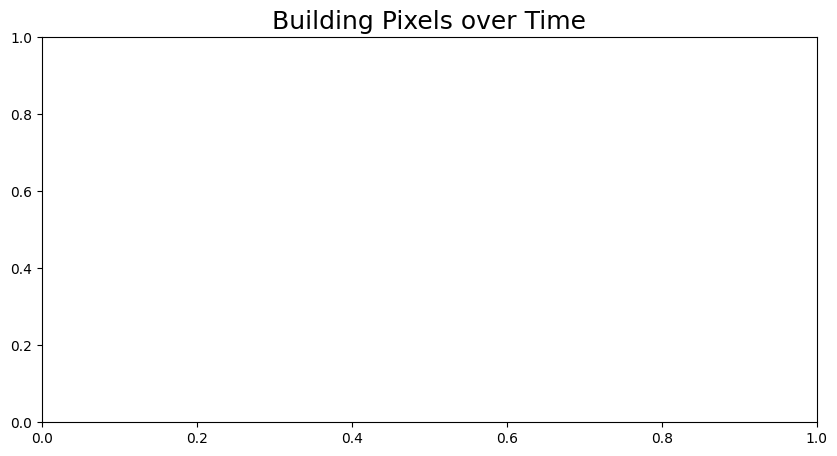

In [31]:
# Plot building pixels over time

plt.figure(figsize=(10, 5))
plt.title('Building Pixels over Time', fontdict={'size': 18})

plt.vlines(x=[idx for idx, time in enumerate(times) if time == '2017-09-01'][0],
           ymin=pixel_counts['building_px'].min(),
           ymax=pixel_counts['building_px'].max(),
           colors='r', linestyles='dashed', alpha=0.5)

plt.vlines(x=[idx for idx, time in enumerate(times) if time == '2018-11-01'][0],
           ymin=pixel_counts['building_px'].min(),
           ymax=pixel_counts['building_px'].max(),
           colors='r', linestyles='dashed', alpha=0.5)

pixel_counts['building_px'].plot()

Looking at the above plot for building pixels, we can broadly quantify the change in buildings in our AOI over the time of our subscription. As indicated on the plot, we see a sudden spike in buildings from September to Novemeber 2017, as the IDP camp settles on the same penninsula. Then - despite some noise in the pixel counts - we can detect the drop in buildings at the end of 2018 as severe flooding alters the camp and surrounding landscape.

Next, let's look at the pattern for roads.

NameError: name 'times' is not defined

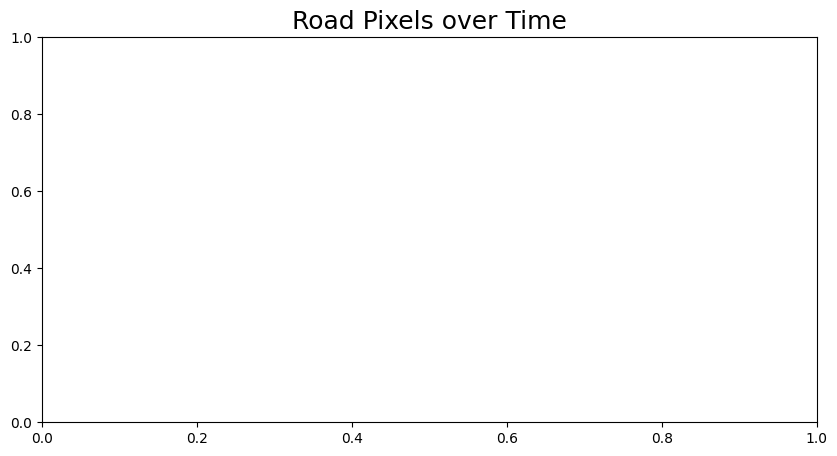

In [32]:
plt.figure(figsize=(10, 5))
plt.title('Road Pixels over Time', fontdict={'size': 18})

plt.vlines(x=[idx for idx, time in enumerate(times) if time == '2017-09-01'][0],
           ymin=pixel_counts['road_px'].min(),
           ymax=pixel_counts['road_px'].max(),
           colors='r', linestyles='dashed', alpha=0.5)

plt.vlines(x=[idx for idx, time in enumerate(times) if time == '2018-11-01'][0],
           ymin=pixel_counts['road_px'].min(),
           ymax=pixel_counts['road_px'].max(),
           colors='r', linestyles='dashed', alpha=0.5)

pixel_counts['road_px'].plot()

Our plot of road pixels over time shows a different trend. While also prone to some month-to-month noise, we can see early that the high number of road pixels is consistent with the construction of the roads scaffolding as early as August, 2017. After the flooding, we see a slight change in road pixels, too. However, this coincides with new road construction in an adjacent camp in our AOI.

Finally, we can visualize the count of combined roads and buildings pixels.

NameError: name 'times' is not defined

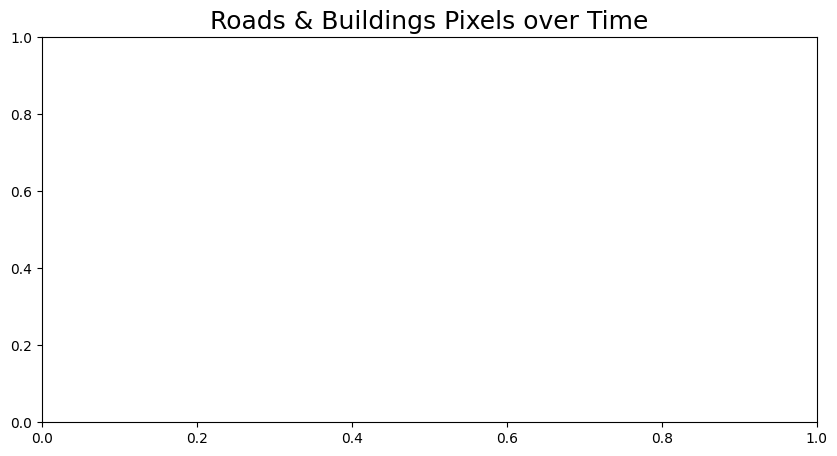

In [33]:
plt.figure(figsize=(10, 5))

plt.title('Roads & Buildings Pixels over Time', fontdict={'size': 18})

plt.vlines(x=[idx for idx, time in enumerate(times) if time == '2017-09-01'][0],
           ymin=pixel_counts['total_px'].min(),
           ymax=pixel_counts['total_px'].max(),
           colors='r', linestyles='dashed', alpha=0.5)

plt.vlines(x=[idx for idx, time in enumerate(times) if time == '2018-11-01'][0],
           ymin=pixel_counts['total_px'].min(),
           ymax=pixel_counts['total_px'].max(),
           colors='r', linestyles='dashed', alpha=0.5)

pixel_counts['total_px'].plot()

Looking at the line chart for combined roads and buildings pixels, we can observe the overall trend in the development and change to this IDP camp. With this simple method of quantifying change, we can readily pick out specific time points with broader changes from a large time range.

With Planet Analytic Feeds, change can be observed in near real-time, enabling enhanced monitoring capabilities, insights at the speed of change, and data-driven decisions.